In [36]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import os
from pythae.models import AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
def get_figure_data(task,plot_figures=True):
    assert task in ['mnist','cifar']
    if task=='cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        cifar_trainset = datasets.CIFAR10(root='../../data', download=True, transform=transform)
        train_dataset = np.transpose(cifar_trainset.data[:-10000],(0,3,1,2))/255
        eval_dataset = np.transpose(cifar_trainset.data[-10000:],(0,3,1,2))/255
        all_dataset = np.transpose(cifar_trainset.data,(0,3,1,2))/255
        print('train_dataset shape:',train_dataset.shape)
        if plot_figures:
            fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
            for i in range(5):
                for j in range(5):
                    axes[i][j].imshow(np.transpose(train_dataset[i*5+j],(1,2,0)))
                    axes[i][j].axis('off')
        return train_dataset,eval_dataset,all_dataset
    elif task=='mnist':
        mnist_trainset = datasets.MNIST(root='../../data', download=True, transform=None)
        train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
        eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.
        all_dataset=mnist_trainset.data.reshape(-1, 1, 28, 28) / 255.
        print('train_dataset shape:',train_dataset.shape)
        if plot_figures:
            fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
            for i in range(5):
                for j in range(5):
                    axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
                    axes[i][j].axis('off')
        return train_dataset,eval_dataset,all_dataset

In [38]:
import logging
from typing import Optional, Union

from typing_extensions import Literal

from pythae.data.datasets import BaseDataset

logger = logging.getLogger(__name__)

# make it print to the console.
console = logging.StreamHandler()
logger.addHandler(console)
logger.setLevel(logging.INFO)


class DataProcessor:
    """
    This is a basic class which preprocesses the data.
    Basically, it takes messy data, detects potential nan, bad types end convert the
    data to a type handled by the VAE models (*i.e.* `torch.Tensor`). Moreover, if the
    data does not have the same shape, a reshaping is applied and data is resized to the
    **minimal shape**.
    """

    def __init__(self):
        pass

    def process_data(
        self, data: Union[np.ndarray, torch.Tensor], batch_size: int = 100
    ) -> torch.Tensor:
        """This function detects potential check the data type, detects nan in input data and
        preprocessed the data so it can be handled by the models.

        Args:
            data (Union[np.ndarray, torch.Tensor]): The data that need to be
                checked. Expected:

                    - | np.ndarray of shape `num_data x n_channels x [optional depth] x
                      | [optional height] x width x ...`
                    - | torch.Tensor of shape `num_data x n_channels x [optional depth] x
                      | [optional height] x width x ...`

            batch_size (int): The batch size used for data preprocessing

        Returns:
            clean_data (torch.tensor): The data that has been cleaned
        """

        if isinstance(data, np.ndarray) or torch.is_tensor(data):
            data = self._process_data_array(data, batch_size=batch_size)

        else:
            raise TypeError(
                "Wrong data type provided. Expected one of "
                "[np.ndarray, torch.Tensor]"
            )

        return data

    @staticmethod
    def to_dataset(data: torch.Tensor, labels: Optional[torch.Tensor] = None):
        """This method converts a set of ``torch.Tensor`` to a
        :class:`~pythae.data.datasets.BaseDataset`

        Args:
            data (torch.Tensor): The set of data as a big torch.Tensor
            labels (torch.Tensor): The targets labels as a big torch.Tensor

        Returns:
            (BaseDataset): The resulting dataset
        """

        if labels is None:
            labels = torch.ones(data.shape[0])

        labels = DataProcessor.to_tensor(labels)
        dataset = BaseDataset(data, labels)

        return dataset

    def _process_data_array(self, data: np.ndarray, batch_size: int = 100):

        num_samples = data.shape[0]
        samples_shape = data.shape

        num_complete_batch = num_samples // batch_size
        num_in_last = num_samples % batch_size

        full_data = []

        for i in range(num_complete_batch):

            # Detect potential nan
            if DataProcessor.has_nan(data[i * batch_size : (i + 1) * batch_size]):
                raise ValueError("Nan detected in input data!")

            processed_data = DataProcessor.to_tensor(
                data[i * batch_size : (i + 1) * batch_size]
            )
            full_data.append(processed_data)

        if num_in_last > 0:
            # Detect potential nan
            if DataProcessor.has_nan(data[-num_in_last:]):
                raise ValueError("Nan detected in input data!")

            processed_data = DataProcessor.to_tensor(data[-num_in_last:])
            full_data.append(processed_data)

        processed_data = torch.cat(full_data)

        assert processed_data.shape == samples_shape, (data.shape, num_samples)

        return processed_data

    @staticmethod
    def to_tensor(data: np.ndarray) -> torch.Tensor:
        """Converts numpy arrays to `torch.Tensor` format

        Args:
            data (np.ndarray): The data to be converted

        Return:
            (torch.Tensor): The transformed data"""

        # check input type
        if not torch.is_tensor(data):
            if not isinstance(data, np.ndarray):
                raise TypeError(
                    " Data must be either of type "
                    f"< 'torch.Tensor' > or < 'np.ndarray' > ({type(data)} provided). "
                    f" Check data"
                )

            else:
                try:
                    data = torch.tensor(data).type(torch.float)

                except (TypeError, RuntimeError) as e:
                    raise TypeError(
                        str(e.args) + ". Potential issues:\n"
                        "- input data has not the same shape in array\n"
                        "- input data with unhandable type"
                    ) from e

        return data

    @staticmethod
    def has_nan(data: torch.Tensor) -> bool:
        """Detects potential nan in input data

        Args:
            data (torch.Tensor): The data to be checked

        Return:
            (bool): True if data contains :obj:`nan`
        """

        if (data != data).sum() > 0:
            return True
        else:
            return False

In [39]:
def get_figure_model(model_name,task):
    assert model_name in ['vae','rae_gp']
    assert task in ['mnist','cifar']
    if task=='mnist':
        input_dim=(1,28,28)
        latent_dim=16
        if model_name=='vae':
            from pythae.models import VAE, VAEConfig
            from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST
            model_config = VAEConfig(
                input_dim=input_dim,
                latent_dim=latent_dim
            )
            model = VAE(
                model_config=model_config,
                encoder=Encoder_ResNet_VAE_MNIST(model_config), 
                decoder=Decoder_ResNet_AE_MNIST(model_config) 
            )
        elif model_name=='rae_gp':
            from pythae.models import RAE_GP, RAE_GP_Config
            from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_AE_MNIST, Decoder_ResNet_AE_MNIST
            model_config = RAE_GP_Config(
                    input_dim=input_dim,
                    latent_dim=latent_dim, # mnist 16
                    embedding_weight=1e-2,
                    reg_weight=1e-4
                )
            model = RAE_GP(
                model_config=model_config,
                encoder=Encoder_ResNet_AE_MNIST(model_config), 
                decoder=Decoder_ResNet_AE_MNIST(model_config) 
            )
    elif task=='cifar':
        input_dim=(3,32,32)
        latent_dim=128
        if model_name=='vae':
            from pythae.models import VAE, VAEConfig
            from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_VAE_CIFAR, Decoder_ResNet_AE_CIFAR
            model_config = VAEConfig(
                input_dim=input_dim,
                latent_dim=latent_dim
            )
            model = VAE(
                model_config=model_config,
                encoder=Encoder_ResNet_VAE_CIFAR(model_config), 
                decoder=Decoder_ResNet_AE_CIFAR(model_config) 
            )
        elif model_name=='rae_gp':
            from pythae.models import RAE_GP, RAE_GP_Config
            from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_AE_CIFAR, Decoder_ResNet_AE_CIFAR
            model_config = RAE_GP_Config(
                    input_dim=input_dim,
                    latent_dim=latent_dim, # mnist 16
                    embedding_weight=1e-2,
                    reg_weight=1e-4
                )
            model = RAE_GP(
                model_config=model_config,
                encoder=Encoder_ResNet_AE_CIFAR(model_config), 
                decoder=Decoder_ResNet_AE_CIFAR(model_config) 
            )
    return model

training VAE

In [ ]:
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
model_name='rae_gp'
task='mnist'
output_dir='my_model/{}/{}/'.format(task,model_name)
config= BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-4,
    batch_size=4096,
    num_epochs=100, # Change this to train the model a bit more
)

train_dataset,eval_dataset,all_dataset=get_figure_data(task)
model=get_figure_model(model_name,task)

pipeline = TrainingPipeline(
    training_config=config,
    model=model
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

In [40]:
fid=FrechetInceptionDistance(feature=2048).to(device)
fid.eval()

def evaluate(pred, target):
    pred=pred.to(device)
    target=target.to(device)
    print('pred shape: ',pred.shape)
    print('target shape: ',target.shape)
    with  torch.no_grad():
        metric = {}
        batch_size = 512
        imgs_dist1 = (pred.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8)
        imgs_dist2 = (target.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8)
        if imgs_dist1.shape[1] == 1: 
            imgs_dist1 = imgs_dist1.repeat(1, 3, 1, 1)
        if imgs_dist2.shape[1] == 1:
            imgs_dist2 = imgs_dist2.repeat(1, 3, 1, 1)
        # fid.reset()
        for idx in tqdm(range(0, len(pred), batch_size)):
            fid.update(imgs_dist1[idx:idx+batch_size], real=False)
            fid.update(imgs_dist2[idx:idx+batch_size], real=True)
        metric["FID"] = fid.compute()
        print('FID : {}'.format(metric["FID"].cpu().item()))
        
def plot_figures(images,output_dir=None,file_name=None):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(2, 2))
    for i in range(5):
        for j in range(5):
            if images.shape[1]==1:
                axes[i][j].imshow(images[i*5+j].cpu().squeeze(0),cmap='gray')
            else:
                axes[i][j].imshow(np.transpose(images[i*5+j].cpu(),(1,2,0)))
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)
    if output_dir is not None:
        fig.savefig(os.path.join(output_dir,file_name))
        
def get_sampler(sampler,model,train_dataset=None):
    assert sampler in ['normal','gmm']
    if sampler=='normal':
        from pythae.samplers import NormalSampler
        normal_samper = NormalSampler(model=model)
        return normal_samper
    elif sampler=='gmm':
        assert train_dataset is not None
        from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig,NormalSampler
        gmm_sampler_config = GaussianMixtureSamplerConfig(n_components=30)
        gmm_sampler = GaussianMixtureSampler(sampler_config=gmm_sampler_config,model=model)
        print('fitting gmm sampler, this process could take several mins')
        gmm_sampler.fit(train_dataset)
        return gmm_sampler

NCP_VAE

In [41]:
import torch
import torch.nn as nn

class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)
    
class ResidualBlockA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockA, self).__init__()
        assert out_channels==in_channels 
        self.conv1 = nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.SiLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))   
        self.out_channels = out_channels
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return out

class ResidualBlockB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockB, self).__init__()
        assert out_channels==2*in_channels
        self.conv1 = nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.SiLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))
        self.factorized_reduction=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=2,padding=0)
        self.out_channels = out_channels
        self.swish=SE_Block(in_channels)
    def forward(self, x):
        # print('residualB')
        # print('x shape',x.shape)
        residual = self.swish(x)
        residual=self.factorized_reduction(residual)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        # print('out shape',out.shape)
        return out

class Binary_Classifier(nn.Module):
    def __init__(self, blockA, blockB, inchannel):
        super(Binary_Classifier, self).__init__()
        self.inplanes = inchannel
        # self.linear1=nn.Linear(16,self.inplanes*16*16)
        # self.conv1 = nn.Sequential(
        #                 nn.ConvTranspose2d(self.inplanes, self.inplanes, 3, 2, padding=1),
        #                 nn.ReLU())
        self.conv1 = nn.Sequential(
                        nn.Conv2d(self.inplanes, self.inplanes, kernel_size=3, stride=1, padding=1),
                        nn.ReLU())
        self.layer0 = self._make_layer(blockA, self.inplanes, self.inplanes, 3)
        self.layer1 = self._make_layer(blockB, self.inplanes, self.inplanes * 2, 1)
        self.layer2 = self._make_layer(blockA, self.inplanes * 2, self.inplanes * 2, 3)
        self.layer3 = self._make_layer(blockB, self.inplanes * 2, self.inplanes * 4,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.inplanes * 4, 1)
        self.sigmoid=nn.Sigmoid()
        
    def _make_layer(self, block, in_channels,out_channels, blocks):
        layers = []
        for i in range(blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        # x=self.linear1(x)
        # x=x.reshape(x.shape[0],self.inplanes,16,16)

        x = self.conv1(x)
        # print(x.shape)
        x = self.layer0(x)
        # print(x.shape)
        x = self.layer1(x)
        # print('layer1 out',x.shape)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
class NCP_VAE(nn.Module):
    def __init__(self,sampler,bin_classifier):
        super(NCP_VAE, self).__init__()
        self.sampler=sampler
        self.bin_classifier=bin_classifier
        self.fid=FrechetInceptionDistance(feature=2048).to(device)
        self.fid.eval()
        self.bin_classifier.eval()
        self.device="cuda" if torch.cuda.is_available() else "cpu"

    @torch.no_grad()
    def get_reweight(self,z):
        x=self.sampler.model.decoder(z)["reconstruction"].detach()
        D=self.bin_classifier(x)
        r=D/(1-D)
        return r

    @torch.no_grad()
    def sample_from_p(self,num_samples):
        """sample from gaussian mixture"""
        try:
            z=torch.tensor(self.sampler.gmm.sample(num_samples)[0]).type(torch.float).to(self.device)
        except Exception:
            z=torch.randn(num_samples, self.sampler.model.latent_dim).to(self.device)
        return z

    @torch.no_grad()
    def sample_from_q(self,input):
        z=self.sampler.model(input).z.detach().to(device)
        return z

    @torch.no_grad()
    def sample_from_ncp(self,num_samples):
        z=self.sample_from_p(num_samples)
        r=self.get_reweight(z).reshape(-1,)
        r/=r.sum()
        idx=torch.multinomial(r,num_samples)
        return z[idx]

    @torch.no_grad()
    def sample(self,num_samples):
        z=self.sample_from_ncp(num_samples)
        return self.sampler.model.decoder(z)["reconstruction"].detach()

    @torch.no_grad()
    def evaluate(self,real_set,num_samples):
        target=real_set[:num_samples]
        pred=self.sample(num_samples)
        metric = {}
        batch_size = 16
        imgs_dist1 = (pred.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8).to(self.device)
        imgs_dist2 = (target.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8).to(self.device)
        if imgs_dist1.shape[1] == 1: 
            imgs_dist1 = imgs_dist1.repeat(1, 3, 1, 1)
        if imgs_dist2.shape[1] == 1:
            imgs_dist2 = imgs_dist2.repeat(1, 3, 1, 1)
        # fid.reset()
        for idx in tqdm(range(0, len(pred), batch_size)):
            fid.update(imgs_dist1[idx:idx+batch_size], real=False)
            fid.update(imgs_dist2[idx:idx+batch_size], real=True)
        # print("fake_samples: ", fid.fake_features_num_samples)
        # print("real_samples: ", fid.real_features_num_samples)
        metric["FID"] = fid.compute()
        return metric

train_dataset shape: torch.Size([50000, 1, 28, 28])
fitting gmm sampler, this process could take several mins
train_dataset shape: torch.Size([50000, 1, 28, 28])


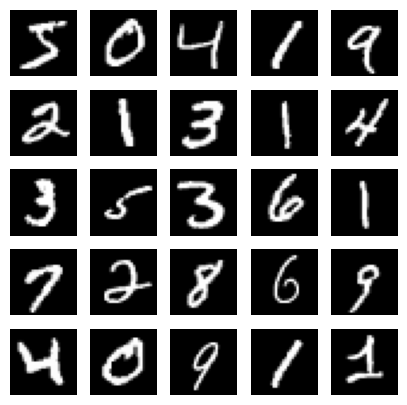

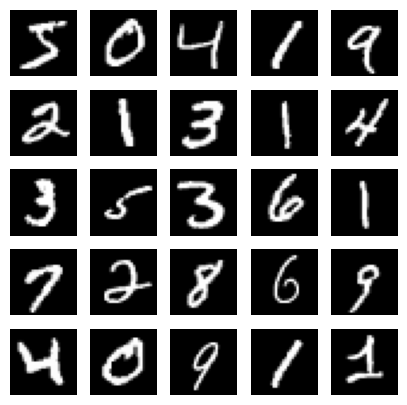

In [42]:
model_name='rae_gp'
task='mnist'
output_dir='my_model/{}/{}/'.format(task,model_name)
last_training = sorted(os.listdir(output_dir))[-1]
output_dir=os.path.join(output_dir, last_training, 'final_model')
trained_model = AutoModel.load_from_folder(output_dir)
train_dataset,eval_dataset,all_dataset=get_figure_data(task)
sampler_gmm=get_sampler('gmm',trained_model,train_dataset)

train_dataset,eval_dataset,all_dataset=get_figure_data(task)
data_processor = DataProcessor()
train_data_processed = data_processor.process_data(train_dataset).to(device)
train_dataset_processed = data_processor.to_dataset(train_data_processed)
train_loader = DataLoader(dataset=train_dataset_processed, batch_size=1024, shuffle=False)

In [43]:
def train_eval_ncp(sampler,data_loader,epochs=10,bs=1024,lr=0.001):
    binary_classifier=Binary_Classifier(ResidualBlockA,ResidualBlockB,3 if task=='cifar' else 1).to(device)
    optimizer=torch.optim.Adam(binary_classifier.parameters(),lr=lr)
    criterion=nn.BCELoss()
    for epoch in range(epochs):
        acc=[]
        losses=[]
        for batch in data_loader:
            num_samples=len(batch['data'])
            q=sampler.model(batch).recon_x
            # p_=torch.tensor(gmm_sampler.gmm.sample(num_samples)[0]).type(torch.float).to(device)
            p=sampler.sample(num_samples)
            input=torch.cat((q,p),dim=0)
            labels=torch.cat((torch.ones(num_samples),torch.zeros(num_samples))).to(device)
            out=binary_classifier(input).squeeze()
            loss=criterion(out,labels) 
            acc.append(np.mean(np.array(out.cpu()>0.5)==np.array(labels.cpu())))
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.cpu().item())
            optimizer.step()
        print('Eopoch :{} | Acc : {:.3f} | Loss : {:.3f} '.format(epoch,np.mean(acc),np.mean(losses)))

    ncp_vae=NCP_VAE(sampler,binary_classifier)
    fid_scores=[]
    # print('acc: ',np.mean(acc))
    print("Evaluation ncp_vae")
    for i in range(1):
        fid_score=ncp_vae.evaluate(torch.tensor(all_dataset),int(0.1 * len(all_dataset)))['FID'].cpu().item()
        fid_scores.append(fid_score)
    print('FID : {}, avg: {:.3F}'.format(fid_scores,np.mean(fid_scores)))
    return ncp_vae

/home/user1/anaconda3/envs/vdvae/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Eopoch :0 | Acc : 0.574 | Loss : 0.677 
Eopoch :1 | Acc : 0.614 | Loss : 0.661 
Eopoch :2 | Acc : 0.621 | Loss : 0.656 
Eopoch :3 | Acc : 0.623 | Loss : 0.653 
Eopoch :4 | Acc : 0.624 | Loss : 0.653 
Eopoch :5 | Acc : 0.630 | Loss : 0.648 
Eopoch :6 | Acc : 0.628 | Loss : 0.648 
Eopoch :7 | Acc : 0.631 | Loss : 0.647 
Eopoch :8 | Acc : 0.630 | Loss : 0.646 
Eopoch :9 | Acc : 0.633 | Loss : 0.644 
Eopoch :10 | Acc : 0.631 | Loss : 0.644 
Eopoch :11 | Acc : 0.634 | Loss : 0.643 
Eopoch :12 | Acc : 0.635 | Loss : 0.642 
Eopoch :13 | Acc : 0.635 | Loss : 0.641 
Eopoch :14 | Acc : 0.635 | Loss : 0.641 
Eopoch :15 | Acc : 0.634 | Loss : 0.643 
Eopoch :16 | Acc : 0.636 | Loss : 0.641 
Eopoch :17 | Acc : 0.635 | Loss : 0.640 
Eopoch :18 | Acc : 0.635 | Loss : 0.640 
Eopoch :19 | Acc : 0.638 | Loss : 0.637 
Eopoch :20 | Acc : 0.637 | Loss : 0.640 
Eopoch :21 | Acc : 0.638 | Loss : 0.637 
Eopoch :22 | Acc : 0.640 | Loss : 0.636 
Eopoch :23 | Acc : 0.640 | Loss : 0.636 
Eopoch :24 | Acc : 0.639 |

/tmp/ipykernel_2213536/3198106306.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid_score=ncp_vae.evaluate(torch.tensor(all_dataset),int(0.1 * len(all_dataset)))['FID'].cpu().item()
100%|██████████| 1500/1500 [00:29<00:00, 50.96it/s]


FID : [14.319608688354492], avg: 14.320


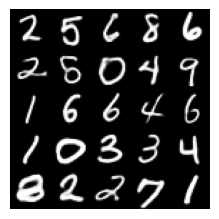

In [44]:
ncp_vae_sampler_gmm=train_eval_ncp(sampler_gmm,train_loader,50,lr=0.01)

plot_figures(ncp_vae_sampler_gmm.sample(25),output_dir,'ncp_rae_gmm_output')

test

POWER Dataset Test

In [1]:
import copy
import torch
from my_utils import plot_hist_marginals
from pythae.data.datasets import DatasetOutput, BaseDataset

class TableDataset(torch.utils.data.Dataset):
    """Wraps a Table and yields each row to use in pythae."""
    
    def __init__(self, data):
        '''
        Args:
            data: dataframe.
        '''
        super(TableDataset, self).__init__()
        self.data = copy.deepcopy(data)
        self.tuples = torch.as_tensor(self.data.values.reshape(-1, 1, self.data.shape[1])).float()
        
    def size(self):
        return len(self.tuples)

    def __len__(self):
        return len(self.tuples)

    def __getitem__(self, idx):
        X = self.tuples[idx]
        return DatasetOutput(
            data=X
        )
    
    def show_histograms(self, split):

        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        plot_hist_marginals(data_split.x)
        plt.show()
        
    def minmax_normalized(self):
        def normalize(x):
            return (x - x.min()) / (x.max() - x.min())
        self.data = self.data.apply(normalize)
    
    def spilt_train_valid(self, valid_rate):
        N_valid = int(valid_rate * self.data.shape[0])
        data_valid = self.data[-N_valid:]
        data = self.data[0:-N_valid]
        
        return data, data_valid    

In [2]:
from data_tabular import CsvTable, power
from train_helpers_tabular import set_up_hyperparams

H, logprint = set_up_hyperparams()

time: Thu Jul 25 00:26:21 2024, message: training model power_test on power


In [3]:
original_data = power(H)
# print(f'{original_data.data[0:1]}')

In [4]:
original_dataset = TableDataset(
    data=original_data.data
)
original_dataset.minmax_normalized()
train_data, valid_data = original_dataset.spilt_train_valid(0.1)

train_dataset = TableDataset(
    data=train_data
)

eval_dataset = TableDataset(
    data=valid_data
)

In [5]:
train_dataset[0]['data']

tensor([[0.0223, 0.0532, 0.2798, 0.0249, 0.0000, 0.0000, 0.0323]])

In [5]:
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(ResBlock, self).__init__()
        assert out_channels==in_channels 
        self.conv1 = nn.Sequential(
                        nn.BatchNorm1d(in_channels),
                        nn.ReLU(),
                        nn.Conv1d(in_channels, middle_channels, kernel_size = 3, stride = 1, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm1d(middle_channels),
                        nn.ReLU(),
                        nn.Conv1d(middle_channels, out_channels, kernel_size = 3, stride = 1, padding = 1))   
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return out

class Encoder_Conv_VAE_Power(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)

        self.input_dim = (1, 7)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.input_layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(self.n_channels, 16, 3, 1, 1),
        )
        self.residual_layers = nn.Sequential(
            *[ResBlock(16, 4, 16) for _ in range(2)]
        )

        self.embedding = nn.Linear(16 * 7, args.latent_dim)
        self.log_var = nn.Linear(16 * 7, args.latent_dim)

    def forward(self, x: torch.Tensor):
        h1 = self.input_layers(x)
        h2 = self.residual_layers(h1)
        h3 = h2.reshape(x.shape[0], -1)
        output = ModelOutput(
            embedding=self.embedding(h3),
            log_covariance=self.log_var(h3)
        )
        return output
    
class Decoder_Conv_VAE_Power(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)
        self.input_dim = (1, 7)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        self.fc = nn.Linear(args.latent_dim, 16 * 7)
        self.residual_layers = nn.Sequential(
            *[ResBlock(16, 4, 16) for _ in range(2)]
        )
        self.output_layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(16, self.n_channels, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor):
        h1 = self.fc(z).reshape(z.shape[0], 16, 7)
        h2 = self.residual_layers(h1)
        h3 = self.output_layers(h2)
        output = ModelOutput(reconstruction=h3)

        return output

In [6]:
from pythae.models import VAEConfig

model_config = VAEConfig(
    input_dim=(1, 7),
    latent_dim=16
    )

encoder = Encoder_Conv_VAE_Power(model_config)
decoder= Decoder_Conv_VAE_Power(model_config)

from typing import Optional
from pythae.models import VAE
import torch.nn.functional as F

class VAE_CE(VAE):
    def __init__(self,
        model_config: VAEConfig,
        encoder: Optional[BaseEncoder] = None,
        decoder: Optional[BaseDecoder] = None,):
        
        super().__init__(model_config, encoder, decoder)

    def get_nll_batch(self, data, n_samples=1):
        """
        Function computed the estimate negative log-likelihood of the model. It uses importance
        sampling method with the approximate posterior distribution. This may take a while.

        Args:
            data (torch.Tensor): The input data from which the log-likelihood should be estimated.
                Data must be of shape [Batch x n_channels x ...]
            n_samples (int): The number of importance samples to use for estimation
        """
        log_p_x = []

        for i in range(n_samples):

            encoder_output = self.encoder(data)
            mu, log_var = encoder_output.embedding, encoder_output.log_covariance

            std = torch.exp(0.5 * log_var)
            z, _ = self._sample_gauss(mu, std)

            log_q_z_given_x = -0.5 * (
                log_var + (z - mu) ** 2 / torch.exp(log_var)
            ).sum(dim=-1, keepdim=True) # shape [B x 1]
            log_p_z = -0.5 * (z ** 2).sum(dim=-1, keepdim=True) # shape [B x 1]
            
            # print(f'log_q_z_given_x: {log_q_z_given_x.shape}')
            # print(f'log_p_z: {log_p_z.shape}')

            recon_x = self.decoder(z)["reconstruction"]

            if self.model_config.reconstruction_loss == "mse":

                log_p_x_given_z = -0.5 * torch.log(F.mse_loss(
                    recon_x.reshape(data.shape[0], -1),
                    data.reshape(data.shape[0], -1),
                    reduction="none",
                )).sum(dim=-1) - torch.tensor(
                    [np.prod(self.input_dim) / 2 * np.log(np.pi * np.e * 2)]
                ).to(
                    data.device
                )  # decoding distribution is assumed unit variance  N(mu, I)

            elif self.model_config.reconstruction_loss == "bce":

                log_p_x_given_z = -F.binary_cross_entropy(
                    recon_x.reshape(data.shape[0], -1),
                    data.reshape(data.shape[0], -1),
                    reduction="none",
                ).sum(dim=-1)

            log_p_x.append(
                    log_p_x_given_z + log_p_z - log_q_z_given_x
                )  # log(2*pi) simplifies

        log_p_x = torch.cat(log_p_x, dim=1) # [B x n_samples]
        # print(f'log_p_x: {log_p_x.shape}')
        
        return torch.logsumexp(log_p_x, dim=1) - np.log(n_samples)
        
model = VAE_CE(
    model_config=model_config,
    encoder=encoder,
    decoder=decoder
).cuda()

In [11]:
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='./saved_models/power_test/test_-1',
    learning_rate=1e-3,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    steps_saving=None,
    num_epochs=10)

pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created ./saved_models/power_test/test_-1/VAE_training_2024-07-24_16-43-41. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 10
 - per_device_train_batch_size: 512
 - per_device_eval_batch_size: 512
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 1/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0699
Eval loss: 0.06
--------------------------------------------------------------------------


Training of epoch 2/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 2/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0599
Eval loss: 0.0599
--------------------------------------------------------------------------


Training of epoch 3/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 3/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0599
--------------------------------------------------------------------------


Training of epoch 4/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 4/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 5/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 5/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 6/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 6/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 7/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 7/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 8/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 8/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 9/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 9/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------


Training of epoch 10/10:   0%|          | 0/3603 [00:00<?, ?batch/s]

Eval of epoch 10/10:   0%|          | 0/401 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 0.0598
Eval loss: 0.0598
--------------------------------------------------------------------------
Training ended!
Saved final model in ./saved_models/power_test/test_-1/VAE_training_2024-07-24_16-43-41/final_model


In [ ]:
# from pythae.models import AutoModel
# import os
# last_training = sorted(os.listdir('./saved_models/power_test/test_-1'))[-1]
# model_rec = AutoModel.load_from_folder(os.path.join('./saved_models/power_test/test_-1', last_training, 'final_model'))
# model.__class__ = VAE_CE

In [7]:
import math
import numpy as np
from my_utils import Card, ErrorMetric, GenerateQuery, estimate_probabilities, make_points

def eval_power(model):
    table = original_data
    rng = np.random.RandomState(1234)
    count = 0
    n_rows = table.data.shape[0] - int(table.data.shape[0] * 0.1) 
    # n_rows = table.data.shape[0] 
    qerrors = []

    for i in range(3000):
            
        cols, ops, vals = GenerateQuery(table.columns, rng, table.data)
        true_card = Card(table.data[:int(table.data.shape[0] * 0.9)], cols, ops, vals)
        # true_card = Card(table.data, cols, ops, vals)
        predicates = []
        for c, o, v in zip(cols, ops, vals):
            predicates.append((c, o, v))
                
        left_bounds = {}
        right_bounds = {}
        
        for idx, attr in enumerate(table.columns):
            col_name = attr.name   
            left_bounds[col_name] = table.mins[idx]
            right_bounds[col_name] = table.maxs[idx] 
                
        table_stats = (table.columns, table.name_to_index, right_bounds, left_bounds)
        
        # print(predicates)
        integration_domain = make_points(table_stats, predicates, table.bias, None, 'minmax')
        
        # print(integration_domain)
        def pdf(x):
            nll = model.get_nll_batch(x)
            
            # print(f'nll: {nll.shape}')
            return nll
        
        prob = estimate_probabilities(pdf, integration_domain, len(table.columns)).item()
        # print(f'prob: {prob}')
        
        if  math.isnan(prob):
            est_card = 1
            count += 1
        elif  math.isinf(prob):   
            est_card = n_rows if prob > 0 else 1
            count += 1
        else:
            est_card = max(prob * n_rows, 1)
            
            if est_card > n_rows:
                count += 1
                est_card = n_rows
                # print(f'prob {prob} true_card: {true_card}')
            
        qerror = ErrorMetric(est_card, true_card)
        qerrors.append(qerror)
        
        if i % 100 == 0:
            print(f'{i} queries done')
    
    return count, qerrors

In [16]:
count, qerrors = eval_power(model)

0 queries done
100 queries done
200 queries done
300 queries done
400 queries done
500 queries done
600 queries done
700 queries done
800 queries done
900 queries done
1000 queries done
1100 queries done
1200 queries done
1300 queries done
1400 queries done
1500 queries done
1600 queries done
1700 queries done
1800 queries done
1900 queries done
2000 queries done
2100 queries done
2200 queries done
2300 queries done
2400 queries done
2500 queries done
2600 queries done
2700 queries done
2800 queries done
2900 queries done


In [17]:
print(f'estimation failed times: {count}')
print('test results')
print(f"Median: {np.median(qerrors)}")
print(f"90th percentile: {np.percentile(qerrors, 90)}")
print(f"95th percentile: {np.percentile(qerrors, 95)}")
print(f"99th percentile: {np.percentile(qerrors, 99)}")
print(f"Max: {np.max(qerrors)}")
print(f"Mean: {np.mean(qerrors)}")

estimation failed times: 1029
test results
Median: 49.392325303045666
90th percentile: 9860.696782362951
95th percentile: 34160.11837027216
99th percentile: 398822.4244167949
Max: 1844352.0
Mean: 17311.7094835641


256
estimation failed times: 2275
test results
Median: 61.312145072691465
90th percentile: 13137.085710979565
95th percentile: 54245.64705882353
99th percentile: 461327.5539670102
Max: 1844352.0
Mean: 19325.10150461067

16
2层
estimation failed times: 1686
test results
Median: 16.94870361887311
90th percentile: 3575.8930232558123
95th percentile: 14070.845913264851
99th percentile: 154568.74266167908
Max: 1844352.0
Mean: 9211.902219659025
8层
estimation failed times: 2269
test results
Median: 55.58625678119349
90th percentile: 13733.809901449096
95th percentile: 48126.172612388735
99th percentile: 461088.0
Max: 1844352.0
Mean: 18189.851955382997

In [21]:
import torch
import torch.nn as nn

class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1)
        return x * y.expand_as(x)
    
class ResidualBlockA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockA, self).__init__()
        assert out_channels == in_channels 
        self.conv1 = nn.Sequential(
                        nn.BatchNorm1d(in_channels),
                        nn.SiLU(),
                        nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm1d(out_channels),
                        nn.SiLU(),
                        nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))   
        self.out_channels = out_channels
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return out

class ResidualBlockB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockB, self).__init__()
        assert out_channels == 2 * in_channels
        self.conv1 = nn.Sequential(
                        nn.BatchNorm1d(in_channels),
                        nn.SiLU(),
                        nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm1d(out_channels),
                        nn.SiLU(),
                        nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))
        self.factorized_reduction=nn.Conv1d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.out_channels = out_channels
        self.swish = SE_Block(in_channels)
    def forward(self, x):
        # print('residualB')
        # print('x shape',x.shape)
        residual = self.swish(x)
        residual = self.factorized_reduction(residual)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        # print('out shape',out.shape)
        return out

class Binary_Classifier(nn.Module):
    def __init__(self, blockA, blockB, inchannel):
        super(Binary_Classifier, self).__init__()
        self.inplanes = inchannel
        self.conv1 = nn.Sequential(
                        nn.Conv1d(self.inplanes, self.inplanes, kernel_size=3, stride=1, padding=1),
                        nn.ReLU())
        self.layer0 = self._make_layer(blockA, self.inplanes, self.inplanes, 3)
        self.layer1 = self._make_layer(blockB, self.inplanes, self.inplanes * 2, 1)
        self.layer2 = self._make_layer(blockA, self.inplanes * 2, self.inplanes * 2, 3)
        self.layer3 = self._make_layer(blockB, self.inplanes * 2, self.inplanes * 4, 1)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(self.inplanes * 4, 1)
        self.sigmoid = nn.Sigmoid()
        
    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        for i in range(blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        # x=self.linear1(x)
        # x=x.reshape(x.shape[0],self.inplanes,16,16)

        x = self.conv1(x)
        # print(x.shape)
        x = self.layer0(x)
        # print(x.shape)
        x = self.layer1(x)
        # print('layer1 out',x.shape)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
class NCP_VAE(nn.Module):
    def __init__(self, sampler, bin_classifier):
        super(NCP_VAE, self).__init__()
        self.sampler = sampler
        self.bin_classifier = bin_classifier
        self.bin_classifier.eval()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    @torch.no_grad()
    def get_reweight(self, z):
        x = self.sampler.model.decoder(z)["reconstruction"].detach()
        D = self.bin_classifier(x)
        r = D / (1 - D)
        return r

    @torch.no_grad()
    def sample_from_p(self, num_samples):
        """sample from gaussian mixture"""
        try:
            z = torch.tensor(self.sampler.gmm.sample(num_samples)[0]).type(torch.float).to(self.device)
        except Exception:
            z = torch.randn(num_samples, self.sampler.model.latent_dim).to(self.device)
        return z

    @torch.no_grad()
    def sample_from_q(self, input):
        z = self.sampler.model(input).z.detach().to(device)
        return z

    @torch.no_grad()
    def _sample_from_ncp(self, num_samples):
        z = self.sample_from_p(num_samples)
        r = self.get_reweight(z).reshape(-1,)
        r /= r.sum()
        idx = torch.multinomial(r, num_samples)
        return z[idx]

    @torch.no_grad()
    def sample(self, num_samples):
        z = self._sample_from_ncp(num_samples)
        return self.sampler.model.decoder(z)["reconstruction"].detach()
    
    @torch.no_grad()
    def get_nll_batch(self, data, n_samples=1):
        log_p_x = []

        for i in range(n_samples):

            encoder_output = self.sampler.model.encoder(data)
            mu, log_var = encoder_output.embedding, encoder_output.log_covariance

            std = torch.exp(0.5 * log_var)
            z, _ = self.sampler.model._sample_gauss(mu, std)
            r = self.get_reweight(z).reshape(-1,)
            r /= r.sum()
            idx = torch.multinomial(r, z.shape[0])
            z = z[idx]

            log_q_z_given_x = -0.5 * (
                log_var + (z - mu) ** 2 / torch.exp(log_var)
            ).sum(dim=-1, keepdim=True) # shape [B x 1]
            log_p_z = -0.5 * (z ** 2).sum(dim=-1, keepdim=True) # shape [B x 1]
            
            # print(f'log_q_z_given_x: {log_q_z_given_x.shape}')
            # print(f'log_p_z: {log_p_z.shape}')

            recon_x = self.sampler.model.decoder(z)["reconstruction"]

            if self.sampler.model.model_config.reconstruction_loss == "mse":

                log_p_x_given_z = -0.5 * torch.log(F.mse_loss(
                    recon_x.reshape(data.shape[0], -1),
                    data.reshape(data.shape[0], -1),
                    reduction="none",
                )).sum(dim=-1) - torch.tensor(
                    [np.prod(self.sampler.model.input_dim) / 2 * np.log(np.pi * np.e * 2)]
                ).to(
                    data.device
                )  # decoding distribution is assumed unit variance  N(mu, I)

            elif self.sampler.model.model_config.reconstruction_loss == "bce":

                log_p_x_given_z = -F.binary_cross_entropy(
                    recon_x.reshape(data.shape[0], -1),
                    data.reshape(data.shape[0], -1),
                    reduction="none",
                ).sum(dim=-1)

            log_p_x.append(
                    log_p_x_given_z + log_p_z - log_q_z_given_x
                )  # log(2*pi) simplifies

        log_p_x = torch.cat(log_p_x, dim=1) # [B x n_samples]
        # print(f'log_p_x: {log_p_x.shape}')
        
        return torch.logsumexp(log_p_x, dim=1) - np.log(n_samples)

In [22]:
def train_ncp(sampler, data_loader, epochs=10, lr=0.001):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    binary_classifier = Binary_Classifier(ResidualBlockA, ResidualBlockB, 1).to(device)
    optimizer = torch.optim.Adam(binary_classifier.parameters(), lr=lr)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        acc = []
        losses = []
        for batch in data_loader:
            num_samples = len(batch['data'])
            q = sampler.model(batch).recon_x
            p = sampler.sample(num_samples)
            input = torch.cat((q, p), dim=0)
            labels = torch.cat((torch.ones(num_samples), torch.zeros(num_samples))).to(device)
            out = binary_classifier(input).squeeze()
            loss = criterion(out, labels) 
            acc.append(np.mean(np.array(out.cpu() > 0.5) == np.array(labels.cpu())))
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.cpu().item())
            optimizer.step()
        print('Eopoch :{} | Acc : {:.3f} | Loss : {:.3f} '.format(epoch,np.mean(acc),np.mean(losses)))

    ncp_vae = NCP_VAE(sampler,binary_classifier)
    
    return ncp_vae

In [24]:
from torch.utils.data import DataLoader

labels = torch.ones(train_dataset.tuples.shape[0]).cuda()
dataset = BaseDataset(train_dataset.tuples.cuda(), labels)
train_loader = DataLoader(dataset=dataset, batch_size=1024, shuffle=False)

from pythae.samplers import NormalSampler

normal_samper = NormalSampler(model=model)
ncp_vae_sampler_normal = train_ncp(normal_samper, train_loader, lr=0.01)

Eopoch :0 | Acc : 0.587 | Loss : 0.667 
Eopoch :1 | Acc : 0.596 | Loss : 0.662 
Eopoch :2 | Acc : 0.596 | Loss : 0.661 
Eopoch :3 | Acc : 0.597 | Loss : 0.661 
Eopoch :4 | Acc : 0.597 | Loss : 0.661 
Eopoch :5 | Acc : 0.597 | Loss : 0.661 
Eopoch :6 | Acc : 0.597 | Loss : 0.661 
Eopoch :7 | Acc : 0.597 | Loss : 0.661 
Eopoch :8 | Acc : 0.598 | Loss : 0.660 
Eopoch :9 | Acc : 0.598 | Loss : 0.660 


In [25]:
count, qerrors = eval_power(ncp_vae_sampler_normal)

/home/user1/anaconda3/envs/vdvae/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


0 queries done
100 queries done
200 queries done
300 queries done
400 queries done
500 queries done
600 queries done
700 queries done
800 queries done
900 queries done
1000 queries done
1100 queries done
1200 queries done
1300 queries done
1400 queries done
1500 queries done
1600 queries done
1700 queries done
1800 queries done
1900 queries done
2000 queries done
2100 queries done
2200 queries done
2300 queries done
2400 queries done
2500 queries done
2600 queries done
2700 queries done
2800 queries done
2900 queries done


In [26]:
print(f'estimation failed times: {count}')
print('test results')
print(f"Median: {np.median(qerrors)}")
print(f"90th percentile: {np.percentile(qerrors, 90)}")
print(f"95th percentile: {np.percentile(qerrors, 95)}")
print(f"99th percentile: {np.percentile(qerrors, 99)}")
print(f"Max: {np.max(qerrors)}")
print(f"Mean: {np.mean(qerrors)}")

estimation failed times: 738
test results
Median: 6.392244421397002
90th percentile: 1903.6204334365323
95th percentile: 7473.371843327265
99th percentile: 102592.07999999697
Max: 1844352.0
Mean: 6002.992186513791
